In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import alphashape
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from mapclassify import Quantiles


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Chicago_Crimes_2012_to_2017.csv')
df = df.dropna(subset=['Latitude', 'Longitude'])
df = df.query('41.64 <= Latitude <= 42.02 and -87.94 <= Longitude <= -87.52')
features = df[['Latitude', 'Longitude']]
scaler = StandardScaler()
X = scaler.fit_transform(features)

Optimal number of clusters (BIC): 14


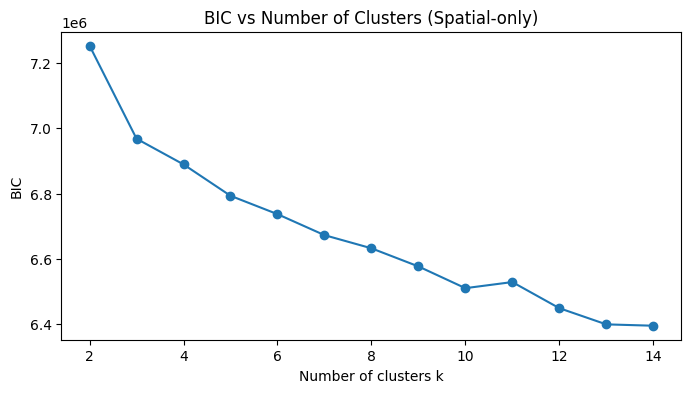

In [ ]:
bics = []
ks = range(2, 15)
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X)
    bics.append(gmm.bic(X))

optimal_k = ks[np.argmin(bics)]
print(f"Optimal number of clusters (BIC): {optimal_k}")

plt.figure(figsize=(8,4))
plt.plot(ks, bics, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('BIC')
plt.title('BIC vs Number of Clusters')
plt.show()

In [ ]:
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
gmm.fit(X)
labels = gmm.predict(X)
df['Cluster'] = labels

In [ ]:
sample_idx = np.random.choice(len(X), size=min(5000, len(X)), replace=False)
sil = silhouette_score(X[sample_idx], labels[sample_idx])
ch = calinski_harabasz_score(X[sample_idx], labels[sample_idx])
db = davies_bouldin_score(X[sample_idx], labels[sample_idx])
print(f"Silhouette Score: {sil:.4f}")
print(f"Calinski-Harabasz Index: {ch:.2f}")
print(f"Davies-Bouldin Score: {db:.4f}")

Silhouette Score: 0.3182
Calinski-Harabasz Index: 4146.12
Davies-Bouldin Score: 0.8640


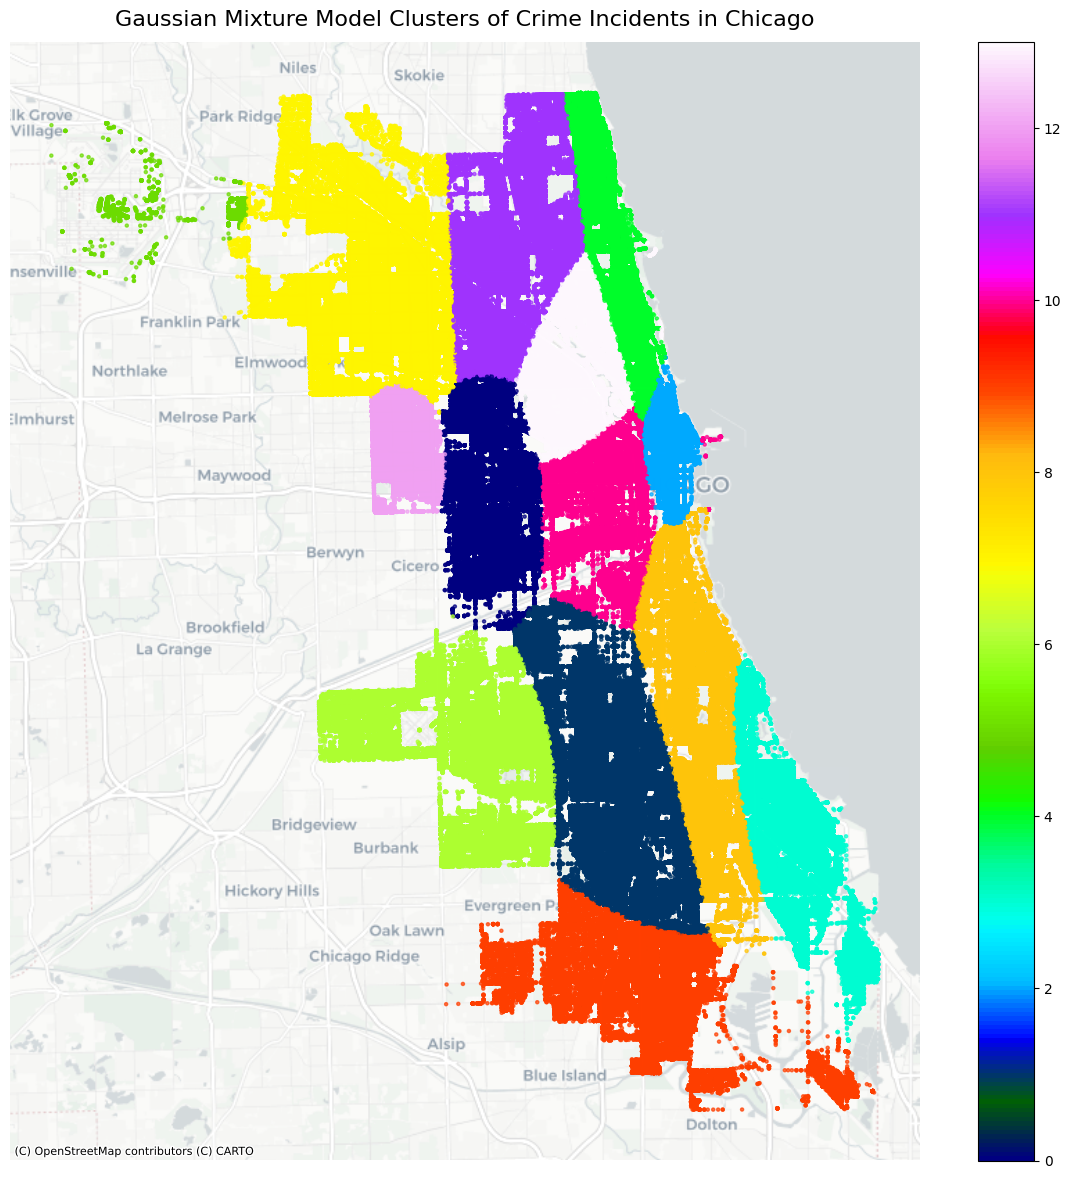

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')
gdf = gdf.to_crs(epsg=3857)  # converting to Web Mercator for mapping
fig, ax = plt.subplots(figsize=(12,12))
gdf.plot(
    ax=ax,
    column='Cluster',
    cmap='gist_ncar',
    markersize=5,
    legend=True,
    alpha=0.7
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=11)
ax.set_axis_off()
ax.set_title('Gaussian Mixture Model Clusters of Crime Incidents in Chicago', fontsize=16, pad=12)
plt.tight_layout()
plt.show()


In [ ]:
print(df['Cluster'].nunique())
print(df['Cluster'].value_counts())


14
Cluster
1     215067
0     175099
8     153961
3     112425
11     94534
7      91939
4      87721
9      86940
6      83767
12     83016
2      82688
10     72914
13     68811
5       8309
Name: count, dtype: int64


In [ ]:
from scipy.stats import entropy
probs = gmm.predict_proba(X)
df['Max_Prob'] = probs.max(axis=1)
df['Entropy'] = entropy(probs.T)
prob_summary = df.groupby('Cluster').agg(
    Crime_Count=('Cluster', 'count'),
    Mean_Prob=('Max_Prob', 'mean'),
    Median_Prob=('Max_Prob', 'median'),
    Min_Prob=('Max_Prob', 'min'),
    Max_Prob_Cluster=('Max_Prob', 'max'),
    Std_Prob=('Max_Prob', 'std')
).reset_index()
print("=== Cluster Probability Summary ===")
print(prob_summary)

=== Cluster Probability Summary ===
    Cluster  Crime_Count  Mean_Prob  Median_Prob  Min_Prob  Max_Prob_Cluster  \
0         0       175099   0.817038     0.880593  0.293874          0.976012   
1         1       215067   0.784881     0.824175  0.324107          0.960574   
2         2        82688   0.880796     0.934135  0.280979          0.965444   
3         3       112425   0.935184     0.995757  0.447588          0.999982   
4         4        87721   0.825177     0.860882  0.293839          0.977314   
5         5         8309   0.935589     0.999977  0.500388          1.000000   
6         6        83767   0.853649     0.933149  0.420195          0.999991   
7         7        91939   0.865699     0.968450  0.296198          1.000000   
8         8       153961   0.821669     0.873537  0.323122          0.972885   
9         9        86940   0.882228     0.954418  0.340023          0.999582   
10       10        72914   0.715977     0.714396  0.293557          0.961884   
11  

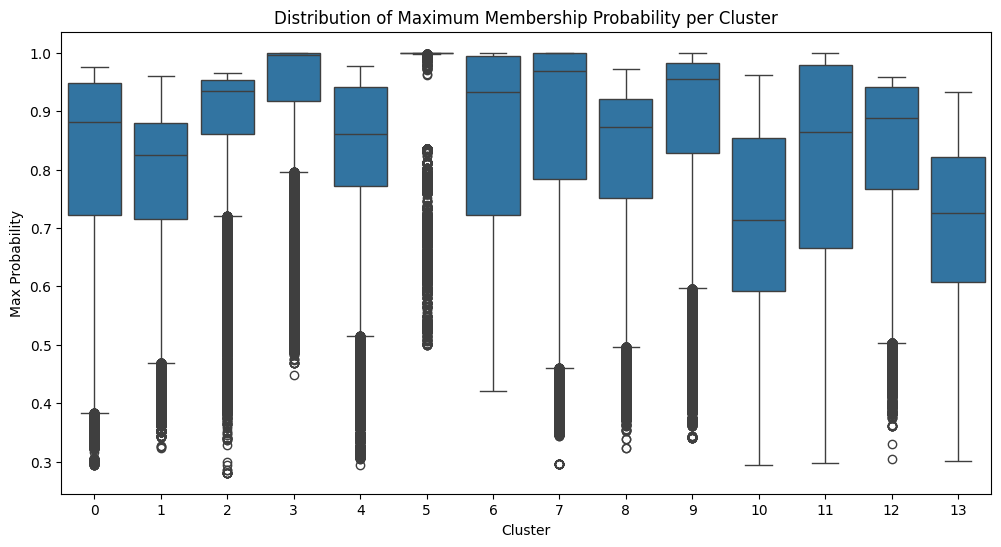

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Cluster', y='Max_Prob', data=df)
plt.title("Distribution of Maximum Membership Probability per Cluster")
plt.ylabel("Max Probability")
plt.show()


In [ ]:
summary = df.groupby('Cluster').agg(
    Crime_Count=('Cluster', 'count'),
    Mean_Latitude=('Latitude', 'mean'),
    Mean_Longitude=('Longitude', 'mean')
).reset_index()
print("=== Cluster Summary ===")
print(summary)

=== Cluster Summary ===
    Cluster  Crime_Count  Mean_Latitude  Mean_Longitude
0         0       175099      41.875023      -87.717047
1         1       215067      41.768778      -87.656440
2         2        82688      41.887774      -87.628143
3         3       112425      41.750088      -87.567855
4         4        87721      41.961179      -87.654912
5         5         8309      41.976480      -87.889386
6         6        83767      41.779287      -87.719513
7         7        91939      41.943138      -87.769735
8         8       153961      41.786931      -87.613400
9         9        86940      41.687415      -87.634098
10       10        72914      41.867758      -87.661355
11       11        94534      41.961190      -87.706586
12       12        83016      41.888359      -87.757094
13       13        68811      41.915382      -87.676484


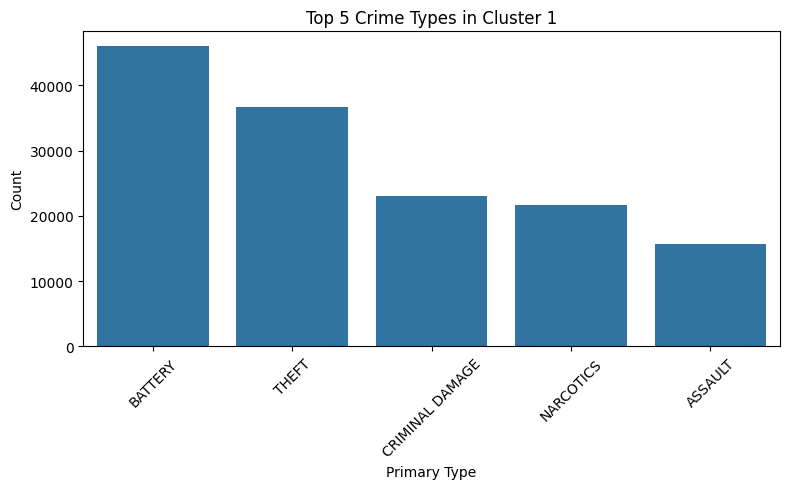

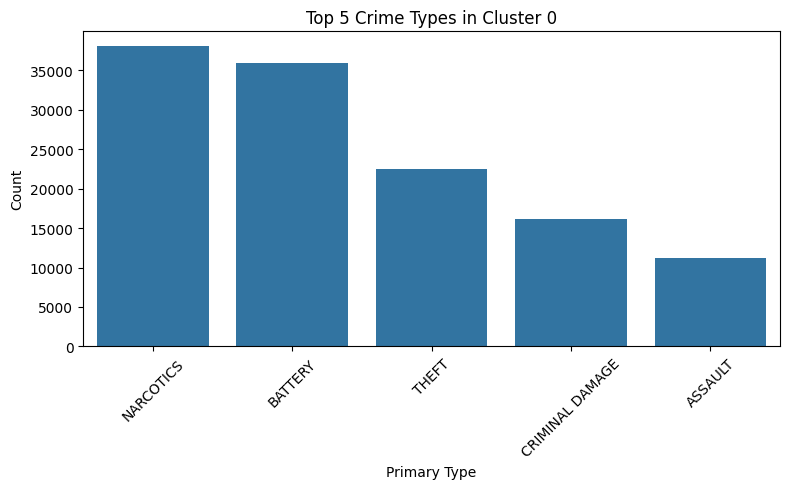

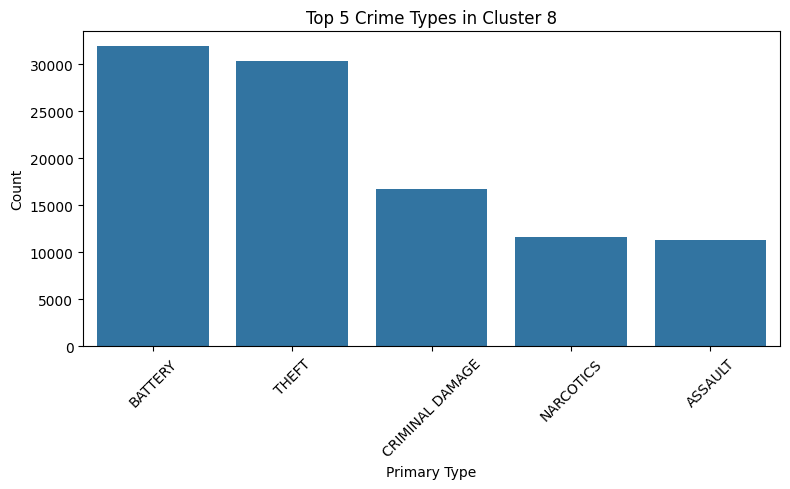

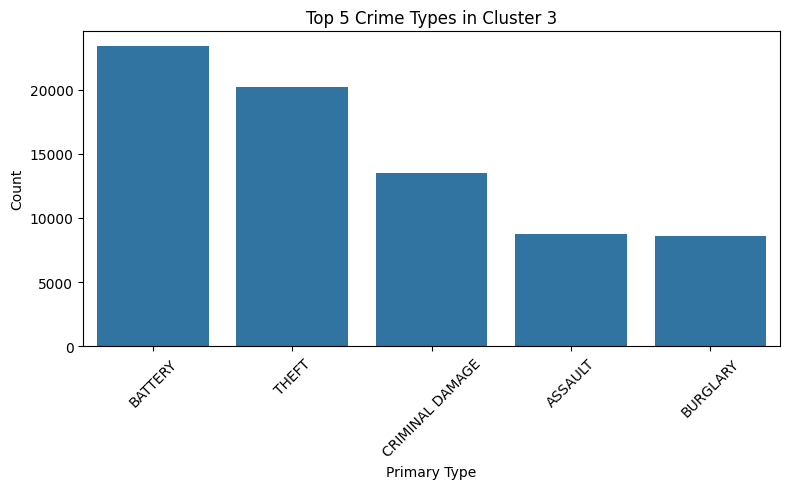

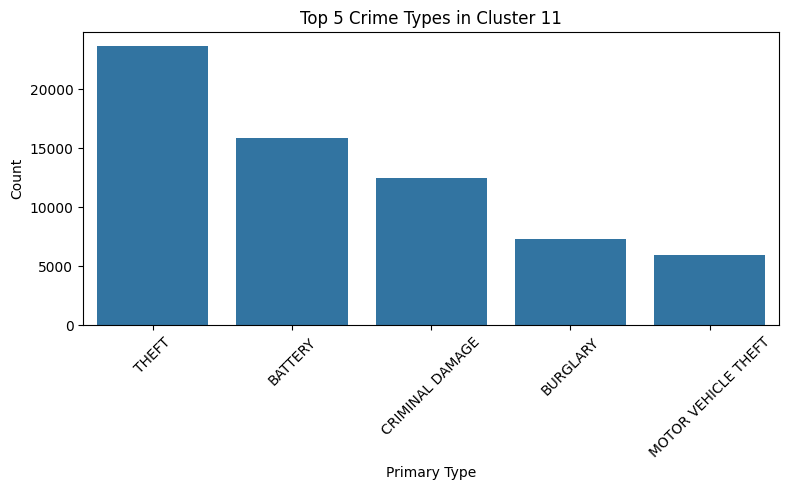

In [ ]:
summary = summary.sort_values('Crime_Count', ascending=False)
top_N_clusters = 5
for cluster_id in summary.head(top_N_clusters)['Cluster']:
    cluster_data = df[df['Cluster'] == cluster_id]
    top_crimes = cluster_data['Primary Type'].value_counts().head(5)
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_crimes.index, y=top_crimes.values)
    plt.title(f"Top 5 Crime Types in Cluster {cluster_id}")
    plt.xlabel("Primary Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<ipython-input-14-d490cc71652d>:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  alpha_shape = group.unary_union.convex_hull


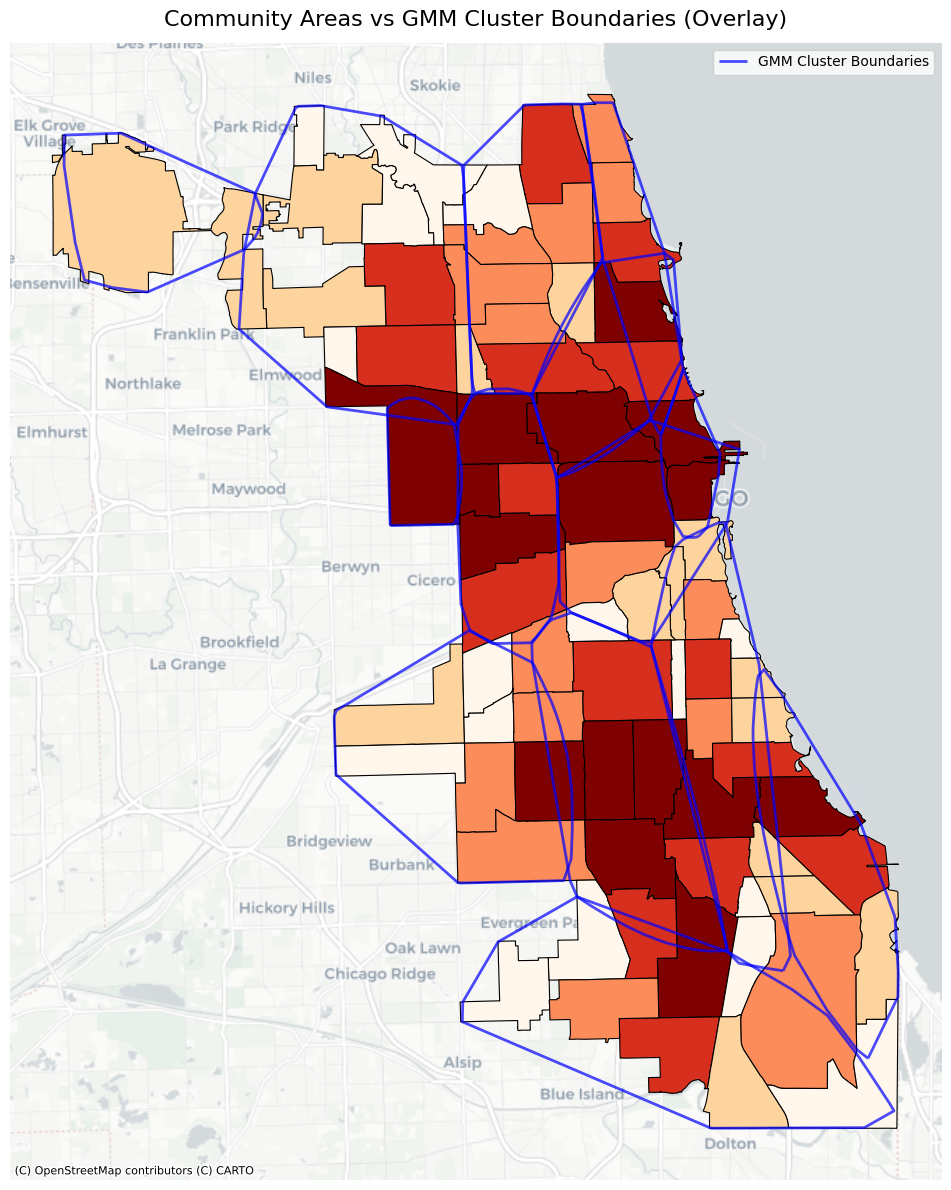

In [ ]:
#concave hulls for each GMM cluster
import alphashape
hulls = []
for cluster_id, group in gdf.groupby('Cluster'):
    if len(group) >= 3:
        try:
            alpha_shape = alphashape.alphashape(group.geometry.values, alpha=0.01)
        except:
            alpha_shape = group.unary_union.convex_hull
    else:
        alpha_shape = group.unary_union.convex_hull
    hulls.append({'geometry': alpha_shape, 'Cluster': cluster_id})

hulls_gdf = gpd.GeoDataFrame(hulls, crs=gdf.crs)
fig, ax = plt.subplots(figsize=(12,12))
community_gdf.plot(
    ax=ax,
    column='incident_count',
    cmap='OrRd',
    scheme='Quantiles',
    k=5,
    edgecolor='black',
    linewidth=0.8,
    legend=True,
    legend_kwds={'title': 'Incidents (Quantiles)', 'loc': 'lower left'}
)
hulls_gdf.boundary.plot(
    ax=ax,
    color='blue',
    linewidth=2,
    alpha=0.7,
    label='GMM Cluster Boundaries'
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=11)
ax.set_axis_off()
ax.set_title('Community Areas vs GMM Cluster Boundaries (Overlay)', fontsize=16, pad=12)
plt.legend()
plt.tight_layout()
plt.show()
